In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

!pip install tensorflow_decision_forests
# TF-DF requires Tensorflow < 2.15 or tf_keras
!pip install tf_keras
!pip install wurlitzer

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tf_keras

### Read in the training data for 2003-2023

In [2]:
# Read in data and clean it up for testing (i.e. use season averages)
DATA_PATH = 'drive/MyDrive/march_madness/2024/'

df = pd.read_csv(DATA_PATH + 'final_data_all_games_2003-2023.csv')

print(df.shape)
df.head()

(361696, 18)


,Season,TeamIDA,TeamIDB,SeedA,SeedB,Weights,WinRatio14A,OffEffA,DefEffA,EFTA,WinRatioA,WinRatio14B,OffEffB,DefEffB,EFTB,WinRatioB,ScoreDiff,WinA
0,2003,1104,1328,10.0,1.0,1.0,0.500000,107.677056,101.630338,0.475785,0.607143,0.800000,113.389612,96.445994,0.512124,0.800000,6,1
1,2003,1272,1393,7.0,3.0,1.0,0.750000,109.889666,97.004974,0.498337,0.793103,0.750000,114.375065,100.143566,0.515151,0.827586,7,1
2,2003,1266,1437,3.0,17.0,1.0,0.500000,120.051019,103.191105,0.536723,0.821429,0.000000,105.369921,102.668103,0.480911,0.500000,12,1
3,2003,1296,1457,17.0,17.0,1.0,0.400000,107.258210,107.247397,0.520538,0.548387,0.500000,104.453154,100.312975,0.500567,0.642857,6,1
4,2003,1400,1208,1.0,17.0,1.0,0.666667,115.644595,100.740654,0.495827,0.785714,0.666667,117.069584,108.587823,0.520926,0.703704,6,1


In [ ]:
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

label = 'WinA'
to_drop = ['Season', 'TeamIDB', 'ScoreDiff']
train, test = split_dataset(df.drop(columns=to_drop), test_ratio=0.3)

print(train.shape)
train.head()

(252926, 15)


,TeamIDA,SeedA,SeedB,Weights,WinRatio14A,OffEffA,DefEffA,EFTA,WinRatioA,WinRatio14B,OffEffB,DefEffB,EFTB,WinRatioB,WinA
4,1400,1.0,17.0,1.0,0.666667,115.644595,100.740654,0.495827,0.785714,0.666667,117.069584,108.587823,0.520926,0.703704,1
5,1458,5.0,17.0,1.0,0.666667,116.323098,96.393896,0.525735,0.758621,0.500000,104.070507,98.660009,0.514259,0.586207,1
6,1161,14.0,17.0,1.0,0.833333,111.685478,110.275473,0.548663,0.566667,0.000000,99.576183,111.567101,0.494368,0.310345,1
7,1186,17.0,17.0,1.0,0.500000,104.070507,98.660009,0.514259,0.586207,0.500000,104.453154,100.312975,0.500567,0.642857,1
8,1194,17.0,17.0,1.0,0.000000,95.911008,107.523566,0.445193,0.222222,0.000000,100.398960,112.074496,0.505175,0.266667,1


In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label, weight='Weights')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=label, weight='Weights')

### Train the model

In [ ]:
tuner = tfdf.tuner.RandomSearch(num_trials=2, use_predefined_hps=True)

model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner, verbose=2)
model.compile(metrics=['accuracy'], weighted_metrics=['accuracy'])
model.fit(train_ds)
model.evaluate(test_ds)

Use 2 thread(s) for training
Use /tmp/tmpmgqu1fy7 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'TeamIDA': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'SeedA': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'SeedB': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'WinRatio14A': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'OffEffA': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'DefEffA': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, 'EFTA': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'WinRatioA': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, 'WinRatio14B': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'OffEffB': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'DefEffB': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, 'EFTB': <tf.Tensor 'data_11:0' shape=(None,) dtype=float64>, 'WinRatioB': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>}
Label: Tensor("data_13:0", shape=

[INFO 24-03-17 03:05:24.1722 UTC kernel.cc:771] Start Yggdrasil model training
[INFO 24-03-17 03:05:24.1722 UTC kernel.cc:772] Collect training examples
[INFO 24-03-17 03:05:24.1722 UTC kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 24-03-17 03:05:24.1728 UTC kernel.cc:391] Number of batches: 253
[INFO 24-03-17 03:05:24.1728 UTC kernel.cc:392] Number of examples: 252926
[INFO 24-03-17 03:05:24.2566 UTC kernel.cc:792] Training dataset:
Number of records: 252926
Number of columns: 15

Number of columns by type:
	NUMERICAL: 14 (93.3333%)
	CATEGORICAL: 1 (6.66667%)

Columns:

NUMERICAL: 14 (93.3333%)
	0: "DefEffA" NUMERICAL num-nas:435 (0.171987%) me

Model trained in 1:52:12.174811
Compiling model...
Model compiled.
109/109 [==============================] - 12s 48ms/step - loss: 0.0000e+00 - accuracy: 0.7534 - weighted_accuracy: 0.7379


[0.0, 0.7534154653549194, 0.7379169464111328]

In [ ]:
tuning_logs = model.make_inspector().tuning_logs()
tuning_logs[tuning_logs.best].iloc[0]

score                                               -1.039128
evaluation_time                                   6731.703258
best                                                     True
split_axis                                     SPARSE_OBLIQUE
sparse_oblique_projection_density_factor                  2.0
sparse_oblique_normalization                             NONE
sparse_oblique_weights                                 BINARY
categorical_algorithm                                  RANDOM
growing_strategy                            BEST_FIRST_GLOBAL
max_num_nodes                                             128
sampling_method                                        RANDOM
subsample                                                 0.8
shrinkage                                                0.02
min_examples                                               10
use_hessian_gain                                         true
num_candidate_attributes_ratio                            0.9
Name: 1,

109/109 [==============================] - 6s 51ms/step


(0.0, 1.0)

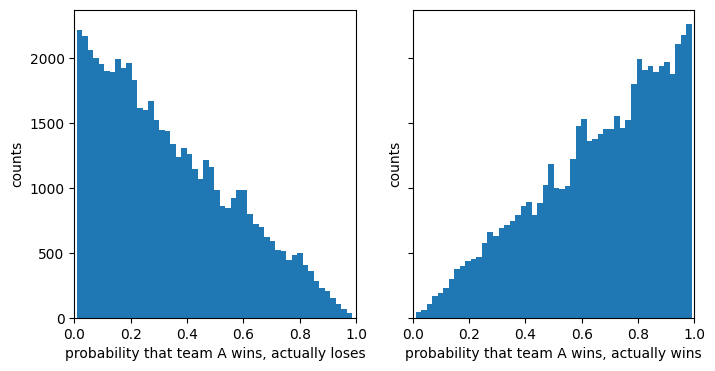

In [ ]:
ypreds = model.predict(test_ds)

fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)

ax[0].hist(ypreds[test.WinA == 0], bins=50)
ax[0].set_xlabel('probability that team A wins, actually loses')
ax[0].set_ylabel('counts')
ax[0].set_xlim(0,1)

ax[1].hist(ypreds[test.WinA == 1], bins=50)
ax[1].set_xlabel('probability that team A wins, actually wins')
ax[1].set_ylabel('counts')
ax[1].set_xlim(0,1)

In [ ]:
# Export the model with the TF.SavedModel format.
model.save('drive/MyDrive/march_madness/2024/final_model.model')

### Predict on 2024 data and create brackets

In [3]:
model = tf_keras.models.load_model('drive/MyDrive/march_madness/2024/final_model.model')

In [12]:
df_2024 = pd.read_csv(DATA_PATH + 'features_2024.csv')
df_2024.head()

,Season,TeamID,Seed,WinRatio14,OffEff,DefEff,EFT,WinRatio
0,2024,1101,17.0,0.333333,101.185469,105.019952,0.471068,0.451613
1,2024,1102,17.0,0.000000,108.731169,119.933816,0.537471,0.290323
2,2024,1103,14.0,0.600000,110.858740,102.551863,0.520358,0.687500
3,2024,1104,4.0,0.333333,124.222709,110.197276,0.565917,0.656250
4,2024,1105,17.0,0.500000,98.146361,107.635701,0.457754,0.333333


In [13]:
# Read in Team names
tmp1 = pd.read_csv(DATA_PATH + 'march-machine-learning-mania-2024/MTeams.csv')
tmp2 = pd.read_csv(DATA_PATH + 'march-machine-learning-mania-2024/WTeams.csv')
df_teams = pd.concat((tmp1,tmp2))
df_teams = df_teams.drop(['FirstD1Season', 'LastD1Season'], axis=1)

# Read in Tourney Slots and add Team Names
df_slots = pd.read_csv(DATA_PATH + 'march-machine-learning-mania-2024/2024_tourney_seeds.csv')
df_slots = df_slots.merge(df_teams, on='TeamID', how='left')

In [15]:
def get_game_data(teamA, teamB, teams, features):

  teamA = teams[teams.TeamID == teamA].drop(['TeamName'], axis=1)
  teamB= teams[teams.TeamID == teamB].drop(['TeamName'], axis=1)

  teamA = pd.merge(teamA, features, on='TeamID', how='left')
  teamB = pd.merge(teamB, features, on='TeamID', how='left').drop('Season', axis=1)

  teamA.rename(columns={
      'TeamID' : 'TeamIDA',
      'Seed' : 'SeedA',
      'OffEff' : 'OffEffA',
      'DefEff' : 'DefEffA',
      'EFT' : 'EFTA',
      'WinRatio' : 'WinRatioA',
      'WinRatio14' : 'WinRatio14A'
  }, inplace=True)

  teamB.rename(columns={
      'TeamID' : 'TeamIDB',
      'Seed' : 'SeedB',
      'OffEff' : 'OffEffB',
      'DefEff' : 'DefEffB',
      'EFT' : 'EFTB',
      'WinRatio' : 'WinRatioB',
      'WinRatio14' : 'WinRatio14B'
  }, inplace=True)

  game = pd.concat([teamA, teamB], axis=1)
  cols = ['Season', 'TeamIDA', 'TeamIDB', 'SeedA', 'SeedB',
          'WinRatio14A', 'OffEffA', 'DefEffA', 'EFTA', 'WinRatioA',
          'WinRatio14B', 'OffEffB', 'DefEffB', 'EFTB', 'WinRatioB']
  game = game[cols]

  return game

# Men's Bracket 2024

In [16]:
# Input arrays for 2024 bracket
gender = 'M'
slots = df_slots[df_slots['Tournament'] == gender]

# populate the 1st round with the seeds
round_of_64 = []
for r in ['W', 'X', 'Y', 'Z']:
  for g in range(8):
    chalk1 = f'{g+1:02d}'
    chalk2 = f'{16-g:02d}'

    seed1 = f'{r}{chalk1}'
    seed2 = f'{r}{chalk2}'

    team1 = slots[slots['Seed'] == seed1]['TeamID'].values[0]
    team2 = slots[slots['Seed'] == seed2]['TeamID'].values[0]

    round_of_64.append([team1, team2])

# map the indices to the next round
map_64 = {
    0 : 0,
    1 : 3,
    2 : 2,
    3 : 1,
    4 : 1,
    5 : 2,
    6 : 3,
    7 : 0
}

# create list for 2nd round
round_of_32 = []
for r in ['W', 'X', 'Y', 'Z']:
    for g in range(4):
      round_of_32.append(['A','B'])

# map the indices to the next round
map_32 = {
    0 : 0,
    1 : 0,
    2 : 1,
    3 : 1
}

# create list for 3rd round
sweet_16 = []
for r in ['W', 'X', 'Y', 'Z']:
    for g in range(2):
      sweet_16.append(['A','B'])

# create list for 4th round
elite_8 = []
for r in ['W', 'X', 'Y', 'Z']:
  elite_8.append(['A','B'])

# create list for 5th round
final_4 = [['A','B'],
           ['A','B']]

# create list for 6th round
ship = ['A','B']

In [17]:
# generate probailities for round of 64
rng = np.random.default_rng(8820)
games_64 = pd.DataFrame()
for g,teams in enumerate(round_of_64):
    games_64 = pd.concat([games_64, get_game_data(teams[0], teams[1], df_teams, df_2024)])

games_64 = games_64.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(games_64)
preds = model.predict(game_X, verbose=0)

print('-- Round of 64 --')
i = 0
j = 0
regions = ['W','X','Y','Z']
for g,teams in enumerate(round_of_64):
  if g % 8 == 0:
      print('\n%s Region:' %(regions[i]))
      i += 1
      j = 0
      t1 = True

  team1 = df_slots[df_slots.TeamID == teams[0]]
  team2 = df_slots[df_slots.TeamID == teams[1]]
  s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
  n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

  if preds[g] >= rng.uniform(): # draw from a distribution to determine who wins

      if t1:
        round_of_32[4*(i-1)+map_64[j]][0] = team1.TeamID.tolist()[0]
        t1 = False
      else:
        round_of_32[4*(i-1)+map_64[j]][1] = team1.TeamID.tolist()[0]
        t1 = True

      print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[g][0]:.4f}')

  else:

      if t1:
        round_of_32[4*(i-1)+map_64[j]][0] = team2.TeamID.tolist()[0]
        t1 = False
      else:
        round_of_32[4*(i-1)+map_64[j]][1] = team2.TeamID.tolist()[0]
        t1 = True

      print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[g][0]:.4f}')

  j += 1


-- Round of 64 --

W Region:
Connecticut (W01) beats Stetson (W16) with probability: 0.9482
Iowa St (W02) beats S Dakota St (W15) with probability: 0.9110
Illinois (W03) beats Morehead St (W14) with probability: 0.8682
Yale (W13) beats Auburn (W04) with probability: 0.1874
San Diego St (W05) beats UAB (W12) with probability: 0.7968
BYU (W06) beats Duquesne (W11) with probability: 0.6960
Washington St (W07) beats Drake (W10) with probability: 0.6867
FL Atlantic (W08) beats Northwestern (W09) with probability: 0.5652

X Region:
North Carolina (X01) beats Howard (X16) with probability: 0.9164
Arizona (X02) beats Long Beach St (X15) with probability: 0.8694
Baylor (X03) beats Colgate (X14) with probability: 0.8615
Alabama (X04) beats Col Charleston (X13) with probability: 0.8307
St Mary's CA (X05) beats Grand Canyon (X12) with probability: 0.8122
New Mexico (X11) beats Clemson (X06) with probability: 0.3570
Dayton (X07) beats Nevada (X10) with probability: 0.6159
Mississippi St (X08) beats

In [18]:
# generate probailities for round of 32
games_32 = pd.DataFrame()
for g,teams in enumerate(round_of_32):
    games_32 = pd.concat([games_32, get_game_data(teams[0], teams[1], df_teams, df_2024)])

games_32 = games_32.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(games_32)
preds = model.predict(game_X, verbose=0)

print('-- Round of 32 --')
i = 0
j = 0
regions = ['W','X','Y','Z']
for g,teams in enumerate(round_of_32):
  if g % 4 == 0:
    print('\n%s Region:' %(regions[i]))
    i += 1
    j = 0
    t1 = True

  team1 = df_slots[df_slots.TeamID == teams[0]]
  team2 = df_slots[df_slots.TeamID == teams[1]]
  s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
  n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

  if preds[g] >= rng.uniform():

    if t1:
        sweet_16[2*(i-1)+map_32[j]][0] = team1.TeamID.tolist()[0]
        t1 = False
    else:
        sweet_16[2*(i-1)+map_32[j]][1] = team1.TeamID.tolist()[0]
        t1 = True

    print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[g][0]:.4f}')

  else:

    if t1:
        sweet_16[2*(i-1)+map_32[j]][0] = team2.TeamID.tolist()[0]
        t1 = False
    else:
        sweet_16[2*(i-1)+map_32[j]][1] = team2.TeamID.tolist()[0]
        t1 = True

    print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[g][0]:.4f}')

  j += 1

-- Round of 32 --

W Region:
Connecticut (W01) beats FL Atlantic (W08) with probability: 0.7545
San Diego St (W05) beats Yale (W13) with probability: 0.7905
BYU (W06) beats Illinois (W03) with probability: 0.3848
Iowa St (W02) beats Washington St (W07) with probability: 0.7250

X Region:
North Carolina (X01) beats Mississippi St (X08) with probability: 0.7544
St Mary's CA (X05) beats Alabama (X04) with probability: 0.4063
Baylor (X03) beats New Mexico (X11) with probability: 0.6874
Dayton (X07) beats Arizona (X02) with probability: 0.2372

Y Region:
Purdue (Y01) beats TCU (Y09) with probability: 0.8078
Gonzaga (Y05) beats Samford (Y13) with probability: 0.8752
Creighton (Y03) beats Oregon (Y11) with probability: 0.6988
Colorado St (Y10) beats Tennessee (Y02) with probability: 0.2199

Z Region:
Houston (Z01) beats Texas A&M (Z09) with probability: 0.8940
Wisconsin (Z05) beats Duke (Z04) with probability: 0.3972
Texas Tech (Z06) beats Kentucky (Z03) with probability: 0.3876
Florida (Z07)

In [19]:
# Predict Sweet 16
# Generate Sweet 16 games
games_16 = pd.DataFrame()
for g,teams in enumerate(sweet_16):
    games_16 = pd.concat([games_16, get_game_data(teams[0], teams[1], df_teams, df_2024)])

games_16 = games_16.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(games_16)
preds = model.predict(game_X, verbose=0)

print('-- Sweet 16 --')
i = 0
j = 0
regions = ['W','X','Y','Z']
for g,teams in enumerate(sweet_16):
  if g % 2 == 0:
    print('\n%s Region:' %(regions[i]))
    i += 1
    j = 0
    t1 = True

  team1 = df_slots[df_slots.TeamID == teams[0]]
  team2 = df_slots[df_slots.TeamID == teams[1]]
  s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
  n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

  if preds[g] >= rng.uniform():

    if t1:
      elite_8[i-1][0] = team1.TeamID.tolist()[0]
      t1 = False
    else:
      elite_8[i-1][1] = team1.TeamID.tolist()[0]
      t1 = True

    print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[g][0]:.4f}')

  else:

    if t1:
      elite_8[i-1][0] = team2.TeamID.tolist()[0]
      t1 = False
    else:
      elite_8[i-1][1] = team2.TeamID.tolist()[0]
      t1 = True

    print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[g][0]:.4f}')

  j += 1

-- Sweet 16 --

W Region:
Connecticut (W01) beats San Diego St (W05) with probability: 0.8364
BYU (W06) beats Iowa St (W02) with probability: 0.3231

X Region:
North Carolina (X01) beats St Mary's CA (X05) with probability: 0.6532
Baylor (X03) beats Dayton (X07) with probability: 0.6558

Y Region:
Gonzaga (Y05) beats Purdue (Y01) with probability: 0.3474
Colorado St (Y10) beats Creighton (Y03) with probability: 0.3151

Z Region:
Houston (Z01) beats Wisconsin (Z05) with probability: 0.8229
Texas Tech (Z06) beats Florida (Z07) with probability: 0.5432


In [20]:
# Predict Elite 8 games
# Generate Elite 8 games
games_8 = pd.DataFrame()
for g,teams in enumerate(elite_8):
    games_8 = pd.concat([games_8, get_game_data(teams[0], teams[1], df_teams, df_2024)])

games_8 = games_8.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(games_8)
preds = model.predict(game_X, verbose=0)

print('-- Elite 8 --')
i = 0
t1 = True
regions = ['W','X','Y','Z']
for g,teams in enumerate(elite_8):
  print('\n%s Region:' %(regions[i]))

  team1 = df_slots[df_slots.TeamID == teams[0]]
  team2 = df_slots[df_slots.TeamID == teams[1]]
  s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
  n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

  if i < 2:
    idx = 0
  else:
    idx = 1

  if preds[g] >= rng.uniform():

    if t1:
      final_4[idx][0] = team1.TeamID.tolist()[0]
      t1 = False
    else:
      final_4[idx][1] = team1.TeamID.tolist()[0]
      t1 = True

    print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[g][0]:.4f}')

  else:

    if t1:
      final_4[idx][0] = team2.TeamID.tolist()[0]
      t1 = False
    else:
      final_4[idx][1] = team2.TeamID.tolist()[0]
      t1 = True

    print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[g][0]:.4f}')

  i += 1

-- Elite 8 --

W Region:
BYU (W06) beats Connecticut (W01) with probability: 0.2669

X Region:
North Carolina (X01) beats Baylor (X03) with probability: 0.6307

Y Region:
Gonzaga (Y05) beats Colorado St (Y10) with probability: 0.6558

Z Region:
Houston (Z01) beats Texas Tech (Z06) with probability: 0.8118


In [21]:
# Predict Final Four
# Generate Final Four games
games_4 = pd.DataFrame()
for g,teams in enumerate(final_4):
    games_4 = pd.concat([games_4, get_game_data(teams[0], teams[1], df_teams, df_2024)])

games_4 = games_4.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(games_4)
preds = model.predict(game_X, verbose=0)

print('-- Final Four --')
i = 0
regions = ['W','X','Y','Z']
for g,teams in enumerate(final_4):

  team1 = df_slots[df_slots.TeamID == teams[0]]
  team2 = df_slots[df_slots.TeamID == teams[1]]
  s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
  n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

  if preds[g] >= rng.uniform():

      ship[i] = teams[0]
      print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[g][0]:.4f}')

  else:

      ship[i] = teams[1]
      print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[g][0]:.4f}')

  i += 1

-- Final Four --
North Carolina (X01) beats BYU (W06) with probability: 0.6948
Houston (Z01) beats Gonzaga (Y05) with probability: 0.7230


In [22]:
# Predict Championship
# Generate Championship game
champ = get_game_data(ship[0], ship[1], df_teams, df_2024)

champ = champ.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(champ)
preds = model.predict(game_X, verbose=0)

teams = ship
team1 = df_slots[df_slots.TeamID == teams[0]]
team2 = df_slots[df_slots.TeamID == teams[1]]
s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

if preds >= rng.uniform():
  print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[0][0]:.4f}')
else:
  print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[0][0]:.4f}')

# Predict the championship score
# Average winning championship score from 2003 - 2023
# Average losing championship score from 2003 - 2023
t = pd.read_csv(DATA_PATH + 'march-machine-learning-mania-2024/MNCAATourneyDetailedResults.csv')
t = t[t.Season < 2024]
t = t[t.DayNum == 154] # only look at championships
print('\nAverage winning score: {:.4f}'.format(t.WScore.mean()))
print('Average losing score: {:.4f}'.format(t.LScore.mean()))
print('Total average score: {:.4f}'.format(t.WScore.mean() + t.LScore.mean()))

North Carolina (X01) beats Houston (Z01) with probability: 0.4803

Average winning score: 74.8000
Average losing score: 66.0500
Total average score: 140.8500


# Women's Bracket 2024

In [23]:
# Input arrays for 2024 bracket
gender = 'W'
slots = df_slots[df_slots['Tournament'] == gender]

# populate the 1st round with the seeds
round_of_64 = []
for r in ['W', 'X', 'Y', 'Z']:
  for g in range(8):
    chalk1 = f'{g+1:02d}'
    chalk2 = f'{16-g:02d}'

    seed1 = f'{r}{chalk1}'
    seed2 = f'{r}{chalk2}'

    team1 = slots[slots['Seed'] == seed1]['TeamID'].values[0]
    team2 = slots[slots['Seed'] == seed2]['TeamID'].values[0]

    round_of_64.append([team1, team2])

# map the indices to the next round
map_64 = {
    0 : 0,
    1 : 3,
    2 : 2,
    3 : 1,
    4 : 1,
    5 : 2,
    6 : 3,
    7 : 0
}

# create list for 2nd round
round_of_32 = []
for r in ['W', 'X', 'Y', 'Z']:
    for g in range(4):
      round_of_32.append(['A','B'])

# map the indices to the next round
map_32 = {
    0 : 0,
    1 : 0,
    2 : 1,
    3 : 1
}

# create list for 3rd round
sweet_16 = []
for r in ['W', 'X', 'Y', 'Z']:
    for g in range(2):
      sweet_16.append(['A','B'])

# create list for 4th round
elite_8 = []
for r in ['W', 'X', 'Y', 'Z']:
  elite_8.append(['A','B'])

# create list for 5th round
final_4 = [['A','B'],
           ['A','B']]

# create list for 6th round
ship = ['A','B']

In [24]:
# generate probailities for round of 64
rng = np.random.default_rng(8820)
games_64 = pd.DataFrame()
for g,teams in enumerate(round_of_64):
    games_64 = pd.concat([games_64, get_game_data(teams[0], teams[1], df_teams, df_2024)])

games_64 = games_64.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(games_64)
preds = model.predict(game_X, verbose=0)

print('-- Round of 64 --')
i = 0
j = 0
regions = ['W','X','Y','Z']
for g,teams in enumerate(round_of_64):
  if g % 8 == 0:
      print('\n%s Region:' %(regions[i]))
      i += 1
      j = 0
      t1 = True

  team1 = df_slots[df_slots.TeamID == teams[0]]
  team2 = df_slots[df_slots.TeamID == teams[1]]
  s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
  n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

  if preds[g] >= rng.uniform(): # draw from a distribution to determine who wins

      if t1:
        round_of_32[4*(i-1)+map_64[j]][0] = team1.TeamID.tolist()[0]
        t1 = False
      else:
        round_of_32[4*(i-1)+map_64[j]][1] = team1.TeamID.tolist()[0]
        t1 = True

      print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[g][0]:.4f}')

  else:

      if t1:
        round_of_32[4*(i-1)+map_64[j]][0] = team2.TeamID.tolist()[0]
        t1 = False
      else:
        round_of_32[4*(i-1)+map_64[j]][1] = team2.TeamID.tolist()[0]
        t1 = True

      print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[g][0]:.4f}')

  j += 1


-- Round of 64 --

W Region:
South Carolina (W01) beats Presbyterian (W16) with probability: 0.9812
Notre Dame (W02) beats Kent (W15) with probability: 0.9272
Oregon St (W03) beats E Washington (W14) with probability: 0.8984
Indiana (W04) beats Fairfield (W13) with probability: 0.8894
Oklahoma (W05) beats FL Gulf Coast (W12) with probability: 0.6664
Nebraska (W06) beats Texas A&M (W11) with probability: 0.6398
Mississippi (W07) beats Marquette (W10) with probability: 0.6104
Michigan St (W09) beats North Carolina (W08) with probability: 0.5644

X Region:
Texas (X01) beats Drexel (X16) with probability: 0.9637
Stanford (X02) beats Norfolk St (X15) with probability: 0.9341
NC State (X03) beats Chattanooga (X14) with probability: 0.9228
Gonzaga (X04) beats UC Irvine (X13) with probability: 0.9169
Utah (X05) beats S Dakota St (X12) with probability: 0.7866
WI Green Bay (X11) beats Tennessee (X06) with probability: 0.4051
Iowa St (X07) beats Maryland (X10) with probability: 0.5950
Alabama (X

In [25]:
# generate probailities for round of 32
games_32 = pd.DataFrame()
for g,teams in enumerate(round_of_32):
    games_32 = pd.concat([games_32, get_game_data(teams[0], teams[1], df_teams, df_2024)])

games_32 = games_32.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(games_32)
preds = model.predict(game_X, verbose=0)

print('-- Round of 32 --')
i = 0
j = 0
regions = ['W','X','Y','Z']
for g,teams in enumerate(round_of_32):
  if g % 4 == 0:
    print('\n%s Region:' %(regions[i]))
    i += 1
    j = 0
    t1 = True

  team1 = df_slots[df_slots.TeamID == teams[0]]
  team2 = df_slots[df_slots.TeamID == teams[1]]
  s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
  n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

  if preds[g] >= rng.uniform():

    if t1:
        sweet_16[2*(i-1)+map_32[j]][0] = team1.TeamID.tolist()[0]
        t1 = False
    else:
        sweet_16[2*(i-1)+map_32[j]][1] = team1.TeamID.tolist()[0]
        t1 = True

    print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[g][0]:.4f}')

  else:

    if t1:
        sweet_16[2*(i-1)+map_32[j]][0] = team2.TeamID.tolist()[0]
        t1 = False
    else:
        sweet_16[2*(i-1)+map_32[j]][1] = team2.TeamID.tolist()[0]
        t1 = True

    print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[g][0]:.4f}')

  j += 1

-- Round of 32 --

W Region:
South Carolina (W01) beats Michigan St (W09) with probability: 0.8951
Indiana (W04) beats Oklahoma (W05) with probability: 0.6815
Nebraska (W06) beats Oregon St (W03) with probability: 0.3587
Notre Dame (W02) beats Mississippi (W07) with probability: 0.7984

X Region:
Texas (X01) beats Alabama (X08) with probability: 0.8787
Gonzaga (X04) beats Utah (X05) with probability: 0.7414
NC State (X03) beats WI Green Bay (X11) with probability: 0.7602
Stanford (X02) beats Iowa St (X07) with probability: 0.8311

Y Region:
Iowa (Y01) beats Princeton (Y09) with probability: 0.8494
Colorado (Y05) beats Portland (Y13) with probability: 0.8817
LSU (Y03) beats MTSU (Y11) with probability: 0.8296
UNLV (Y10) beats UCLA (Y02) with probability: 0.2039

Z Region:
USC (Z01) beats Michigan (Z09) with probability: 0.8278
Baylor (Z05) beats Virginia Tech (Z04) with probability: 0.4014
Syracuse (Z06) beats Connecticut (Z03) with probability: 0.2601
Ohio St (Z02) beats Duke (Z07) wit

In [26]:
# Predict Sweet 16
# Generate Sweet 16 games
games_16 = pd.DataFrame()
for g,teams in enumerate(sweet_16):
    games_16 = pd.concat([games_16, get_game_data(teams[0], teams[1], df_teams, df_2024)])

games_16 = games_16.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(games_16)
preds = model.predict(game_X, verbose=0)

print('-- Sweet 16 --')
i = 0
j = 0
regions = ['W','X','Y','Z']
for g,teams in enumerate(sweet_16):
  if g % 2 == 0:
    print('\n%s Region:' %(regions[i]))
    i += 1
    j = 0
    t1 = True

  team1 = df_slots[df_slots.TeamID == teams[0]]
  team2 = df_slots[df_slots.TeamID == teams[1]]
  s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
  n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

  if preds[g] >= rng.uniform():

    if t1:
      elite_8[i-1][0] = team1.TeamID.tolist()[0]
      t1 = False
    else:
      elite_8[i-1][1] = team1.TeamID.tolist()[0]
      t1 = True

    print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[g][0]:.4f}')

  else:

    if t1:
      elite_8[i-1][0] = team2.TeamID.tolist()[0]
      t1 = False
    else:
      elite_8[i-1][1] = team2.TeamID.tolist()[0]
      t1 = True

    print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[g][0]:.4f}')

  j += 1

-- Sweet 16 --

W Region:
South Carolina (W01) beats Indiana (W04) with probability: 0.7980
Nebraska (W06) beats Notre Dame (W02) with probability: 0.2276

X Region:
Texas (X01) beats Gonzaga (X04) with probability: 0.6547
NC State (X03) beats Stanford (X02) with probability: 0.3048

Y Region:
Iowa (Y01) beats Colorado (Y05) with probability: 0.7890
UNLV (Y10) beats LSU (Y03) with probability: 0.1968

Z Region:
USC (Z01) beats Baylor (Z05) with probability: 0.5946
Syracuse (Z06) beats Ohio St (Z02) with probability: 0.3075


In [27]:
# Predict Elite 8 games
# Generate Elite 8 games
games_8 = pd.DataFrame()
for g,teams in enumerate(elite_8):
    games_8 = pd.concat([games_8, get_game_data(teams[0], teams[1], df_teams, df_2024)])

games_8 = games_8.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(games_8)
preds = model.predict(game_X, verbose=0)

print('-- Elite 8 --')
i = 0
t1 = True
regions = ['W','X','Y','Z']
for g,teams in enumerate(elite_8):
  print('\n%s Region:' %(regions[i]))

  team1 = df_slots[df_slots.TeamID == teams[0]]
  team2 = df_slots[df_slots.TeamID == teams[1]]
  s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
  n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

  if i < 2:
    idx = 0
  else:
    idx = 1

  if preds[g] >= rng.uniform():

    if t1:
      final_4[idx][0] = team1.TeamID.tolist()[0]
      t1 = False
    else:
      final_4[idx][1] = team1.TeamID.tolist()[0]
      t1 = True

    print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[g][0]:.4f}')

  else:

    if t1:
      final_4[idx][0] = team2.TeamID.tolist()[0]
      t1 = False
    else:
      final_4[idx][1] = team2.TeamID.tolist()[0]
      t1 = True

    print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[g][0]:.4f}')

  i += 1

-- Elite 8 --

W Region:
South Carolina (W01) beats Nebraska (W06) with probability: 0.9338

X Region:
Texas (X01) beats NC State (X03) with probability: 0.7699

Y Region:
Iowa (Y01) beats UNLV (Y10) with probability: 0.8154

Z Region:
USC (Z01) beats Syracuse (Z06) with probability: 0.7069


In [28]:
# Predict Final Four
# Generate Final Four games
games_4 = pd.DataFrame()
for g,teams in enumerate(final_4):
    games_4 = pd.concat([games_4, get_game_data(teams[0], teams[1], df_teams, df_2024)])

games_4 = games_4.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(games_4)
preds = model.predict(game_X, verbose=0)

print('-- Final Four --')
i = 0
regions = ['W','X','Y','Z']
for g,teams in enumerate(final_4):

  team1 = df_slots[df_slots.TeamID == teams[0]]
  team2 = df_slots[df_slots.TeamID == teams[1]]
  s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
  n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

  if preds[g] >= rng.uniform():

      ship[i] = teams[0]
      print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[g][0]:.4f}')

  else:

      ship[i] = teams[1]
      print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[g][0]:.4f}')

  i += 1

-- Final Four --
Texas (X01) beats South Carolina (W01) with probability: 0.4302
Iowa (Y01) beats USC (Z01) with probability: 0.6074


In [29]:
# Predict Championship
# Generate Championship game
champ = get_game_data(ship[0], ship[1], df_teams, df_2024)

champ = champ.drop(['Season', 'TeamIDB'], axis=1)
game_X = tfdf.keras.pd_dataframe_to_tf_dataset(champ)
preds = model.predict(game_X, verbose=0)

teams = ship
team1 = df_slots[df_slots.TeamID == teams[0]]
team2 = df_slots[df_slots.TeamID == teams[1]]
s1, s2 = team1.Seed.tolist()[0], team2.Seed.tolist()[0]
n1, n2 = team1.TeamName.tolist()[0], team2.TeamName.tolist()[0]

if preds >= rng.uniform():
  print(f'{n1} ({s1}) beats {n2} ({s2}) with probability: {preds[0][0]:.4f}')
else:
  print(f'{n2} ({s2}) beats {n1} ({s1}) with probability: {1-preds[0][0]:.4f}')

# Predict the championship score
# Average winning championship score from 2003 - 2023
# Average losing championship score from 2003 - 2023
t = pd.read_csv(DATA_PATH + 'march-machine-learning-mania-2024/WNCAATourneyDetailedResults.csv')
t = t[t.Season < 2024]
t = t[t.DayNum >= 153] # only look at championships, except this doesn't work as well for Women's
print('\nAverage winning score: {:.4f}'.format(t.WScore.mean()))
print('Average losing score: {:.4f}'.format(t.LScore.mean()))
print('Total average score: {:.4f}'.format(t.WScore.mean() + t.LScore.mean()))

Texas (X01) beats Iowa (Y01) with probability: 0.4847

Average winning score: 73.7778
Average losing score: 59.8519
Total average score: 133.6296
